## Try and identify the point of calibration for each linac
- Might need to look at gradients, or at mean/median values either side of a point etc.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.date_dayfirst", True)
pd.set_option("display.date_yearfirst", False)
#pd.describe_option('display.date_yearfirst')
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid') #matplotlib now also has styles which can be imported for ease
#plt.style.use('ggplot')
%matplotlib inline
import datetime as dt
from scipy import stats
from scipy import interpolate
import matplotlib.dates as mdates

In [2]:
filepath = 'Data to Import/OP_pickles/OP_all_data_5perc_cutoff_NEW-2017.pkl'
all_data = pd.read_pickle(filepath)

## ensure dates are dates
#all_data['Date'] = pd.to_datetime(all_data['Date'])

## add a column with the date delta from minimum date
#all_data['date_delta'] = (all_data['Date']-all_data['Date'].min()) / np.timedelta64(1,'D')

## set some of the values to Farmer for Linac 13 and 20
#for i, row in all_data[(all_data['Linac_ID']==13) | (all_data['Linac_ID']==20)].iterrows():
#    if all_data['Measurement_Device'][i] == 'Farmer Chamber in Water':
#        all_data.set_value(i,'Farmer','Farmer')

## set some of the values to Farmer for centre 51 and 52
#for i, row in all_data[(all_data['Centre_ID']==51) | (all_data['Centre_ID']==52)].iterrows():
#    #if all_data['Measurement_Device'][i] == 'Farmer':
#    all_data.set_value(i,'Farmer','Farmer')

In [3]:
## save the data as csv
#all_data.to_csv('Data to Import/OP_pickles/OP_all_data_5perc_cutoff_NEW.csv')
all_data.head(3)

,Centre_ID,NHS_PP,Group,Linac_Manufacturer,Linac_Model,Linac_Install_Date,Linac_ID,Date,Measurement_Device,OP_Dif,Recording,Comments,Week,Month,Farmer,date_delta,Short_Date,weekday
0,1,NHS,5,Elekta,Agility,2014,1,2015-01-06,Farmer,0.5,Paper,NaN,2,1,Farmer,5.0,06/01/2015,1
1,1,NHS,5,Elekta,Agility,2014,1,2015-01-16,Farmer,-0.9,Paper,NaN,3,1,Farmer,15.0,16/01/2015,4
2,1,NHS,5,Elekta,Agility,2014,1,2015-01-19,Farmer,-0.6,Paper,NaN,4,1,Farmer,18.0,19/01/2015,0


## Get an individual linacs data

In [13]:
linac = 13 #linacs 10 and 11 both a calibration within the data
linacs = sorted(all_data['Linac_ID'].unique()) # list of all linacs
device = 'Farmer' # only use non-farmer data as there is more of it and calibrations should show up better?
print(linacs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204]


In [5]:
## plot each linacs output - Farmer + other
linacs=[10]
for linac in linacs:
    df_l = all_data[(all_data['Linac_ID']==linac)].sort_values(by='Date')
    df_l_farmer = all_data[(all_data['Linac_ID']==linac)&(all_data['Farmer']=='Farmer')].sort_values(by='Date')
    df_l_non = all_data[(all_data['Linac_ID']==linac)&(all_data['Farmer']!='Farmer')].sort_values(by='Date')
    plt.plot(df_l['Date'],df_l['OP_Dif'],label='OP',alpha=0.6,lw=0.5)
    if df_l_non is not None:
        plt.plot(df_l_non['Date'],df_l_non['OP_Dif'],label='Non-Farmer',ls='',marker='o',c='green',ms=2.5)
        all_mean_non = df_l_non['OP_Dif'].mean()
        plt.axhline(all_mean_non,alpha=0.5,color='green',label='Non-Farmer Mean')
    if df_l_farmer is not None:
        plt.plot(df_l_farmer['Date'],df_l_farmer['OP_Dif'],label='Farmer',ls='',marker='^',c='red',ms=3)
        all_mean_farmer = df_l_farmer['OP_Dif'].mean()
        plt.axhline(all_mean_farmer,alpha=0.5,color='red',label='Farmer Mean')
    
    plt.axhline(0,alpha=0.8,color='black')
        
    plt.ylim(-3,3)
    plt.xlim('1-jan-15','1-july-15')
    plt.ylabel('Output (%)')
    plt.xlabel('Date')
    plt.title('Output data for linac ' + str(linac))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #savename = 'OPs\Linac_OPs\OP-only\op-sep-mean-farmer-non-'+str(linac)+'.png'
    #plt.savefig(savename,bbox_inches='tight',dpi=300)
    print(linac)
    plt.close()
    #plt.show
    

10


## Create histograms (and stats) for all measurements, and seperated Farmer/Non

All Data number: 24501
All Data mean: -0.01
All Data SD: 0.88
Farmer Only number: 4310
Farmer Only mean: 0.17
Farmer Only SD: 0.77
Non-Farmer Only number: 20191
Non-Farmer Only mean: -0.05
Non-Farmer Only SD: 0.9


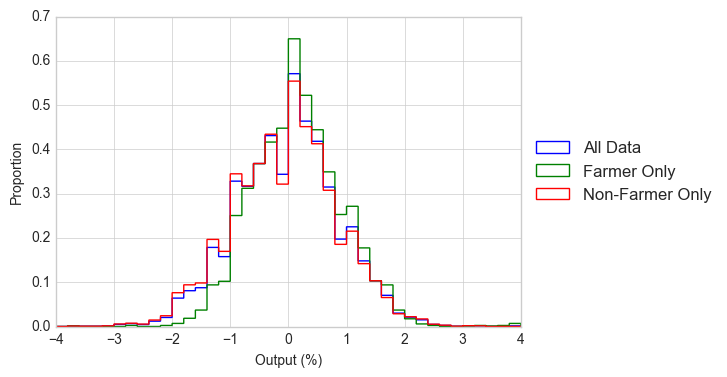

In [6]:
hist_all = all_data['OP_Dif']
hist_farmer = all_data[all_data['Farmer'] == 'Farmer']['OP_Dif']
hist_non = all_data[all_data['Farmer'] != 'Farmer']['OP_Dif']

for data in [(hist_all,'All Data'), (hist_farmer,'Farmer Only'), (hist_non,'Non-Farmer Only')]:
    plt.hist(data[0],bins=40,normed=True,label=data[1],range=(-4,4),histtype='step')
    print(data[1] + ' number: ' + str(len(data[0])))
    print(data[1] + ' mean: ' + str(round(data[0].mean(),2)))
    print(data[1] + ' SD: ' + str(round(data[0].std(),2)))
#plt.xlim(-4,4)
plt.xlabel('Output (%)')
plt.ylabel('Proportion')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#savename = 'OPs\Linac_OPs\OP-only\hist-all-seperate.png'
#plt.savefig(savename,bbox_inches='tight',dpi=300)
plt.show()

## Distribution of install year and number of measurements?

In [9]:
all_data.head(2)

,Centre_ID,NHS_PP,Group,Linac_Manufacturer,Linac_Model,Linac_Install_Date,Linac_ID,Date,Measurement_Device,OP_Dif,Recording,Comments,Week,Month,Farmer,date_delta,Short_Date,weekday
0,1,NHS,5,Elekta,Agility,2014,1,2015-01-06,Farmer,0.5,Paper,NaN,2,1,Farmer,5.0,06/01/2015,1
1,1,NHS,5,Elekta,Agility,2014,1,2015-01-16,Farmer,-0.9,Paper,NaN,3,1,Farmer,15.0,16/01/2015,4


In [14]:
## just filtering by the year gives the number of measurements in that year...
## 1- get list of unique years for each linac and put in list.
## 2- count number in each year (between min and max values)
## 3- use list of counts for each year to then plot/stats etc

## 1- get list of the years for the linacs which have a known install year
import numbers
year_list = []
for linac in linacs:
    year_list.append(all_data[all_data['Linac_ID']==linac]['Linac_Install_Date'].unique())
year_vals = list(np.concatenate(year_list, axis=0))
print(year_vals)
year_nums = []

for val in year_vals:
    if isinstance(val, numbers.Number) == True:
        year_nums.append(val)
print('ynum',year_nums)
print('Number of linacs with known install years:', len(year_nums))

## 2 - create a list of years and count the number of times this is in the above list
year_list = [x for x in range(1998,2017)]
print(year_list)
year_count = []
for year in year_list:
    year_count.append(year_nums.count(year))
print(year_count)

## create year_count as a percentage

year_count_perc = [100*x/len(year_nums) for x in year_count]

## create a plot to show the distribution - choose from bar or line chart below
#plt.plot(year_list, year_count_perc,marker='o')
plt.bar(year_list,year_count_perc,width=0.5,tick_label=year_list,align='center',color='teal',alpha=0.8)
#plt.hist(year_nums,bins=16) ##  equivalent histgram production

plt.xlim(1998,2016)
plt.title('Distribution of Linac Install Year')
plt.xlabel('Install Year')
plt.xticks(rotation=90)
plt.ylabel('Proportion of Linacs (%)')
#savename = 'OPs\Linac_OPs\OP-only\install_year_dist.png'
#plt.savefig(savename,bbox_inches='tight',dpi=300)
plt.show()

## calculate how many are older than n_years old
n_years = 10 ## should = 47?
current_year = 2015 # use this is the currewnt date as this was true when data was collected.

old_linac_count = 0
test_year = min(year_list)
i=0
while test_year <=(current_year-n_years): ##  this loops through weach year from the beginning
    old_linac_count = old_linac_count + year_count[i]
    #print(test_year,old_linac_count)
    i+=1
    test_year +=1
print('Number of linacs older than ' + str(n_years) + ' years is ' + str(old_linac_count) + ' of ' + str(len(year_nums)) + ' (' + str(round(100*old_linac_count/len(year_nums),2)) + '%)')

['2014', '2012', '2007', '2009', '2014', '2012', '2005', '2005', '2015', '2006', '2004', '2003', '2003', '2005', '2010', '2010', '2010', '2012', '2013', '2014', '?', '?', '?', '?', '?', '?', '2010', '2010', '1999', '2007', '2006', '2010', '2013', '2013', '2008', '2010', '2006', '2007', '2005', '2009', '2009', '2009', '2009', '2000', '2004', '2004', '2004', '2005', '2002', '2007', '2006', '2006', '2012', '2013', '2014', '2015', '2006', '2006', '2006', '2007', '2007', '2007', '2012', '2013', '2014', '2008', '2004', '2008', '2008', '2008', '2003', '2008', '2010', '2011', '2000', '2001', '2002', '2004', '2013', '2013', '2007', '2008', '2009', '2009', '?', '?', '?', '?', '2003', '2002', '2002', '2006', '2006', '2007', '2004', '2002', '2002', '2005', '2007', '2007', '2013', '2013', '2014', '2014', '2005', '2013', '2011', '2001', '2007', '2007', '2006', '2007', '2014', '?', '?', '?', '?', '?', '?', '?', '2005', '2006', '2007', '2015', '2004', '2015', '2015', '2015', '2014', '2003', '2006', '2

ZeroDivisionError: division by zero

## Identify calibration based on the setting a threshold on the gradient
- This fails for linac 11 as there is a spike in the data which is not a calibration
- Could take a second derivative?

num cal points identified:  4


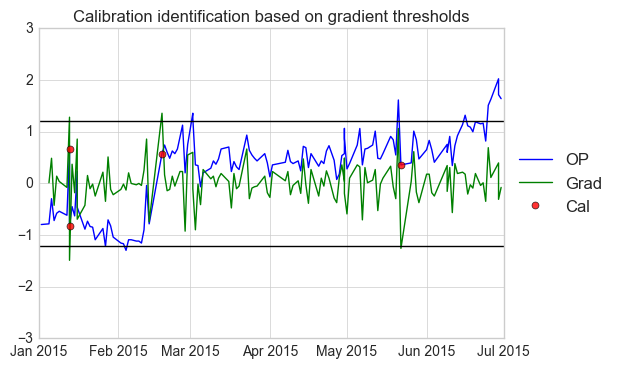

In [15]:
## get single linacs non-farmer data
df_l = all_data[(all_data['Linac_ID']==linac) & (all_data['Measurement_Device']!=device)].sort_values(by='Date')
if len(df_l)==0:
    df_l = all_data[(all_data['Linac_ID']==linac)].sort_values(by='Date')

## calculate the differential of the OPs and identify any calibration points baased on large gradients
df_l['grad']=df_l['OP_Dif'].diff()

## auto threshold based on SD
## calc SD of the grad
sd_grad = df_l['grad'].std()
thres = 3*sd_grad ## 3 seems a reasonable value to start with

## filter out those above/below a threshold
df_l_cal = df_l[(df_l['grad']>thres) | (df_l['grad']<-thres)]
print('num cal points identified: ',len(df_l_cal))

## plot the data and gradient
plt.plot(df_l['Date'],df_l['OP_Dif'],label='OP')
plt.plot(df_l['Date'],df_l['grad'],label='Grad')
## works better when date is included as likely multiple measurements on the same day?

## plot the identified points that exceed the gradient threshold
plt.plot(df_l_cal['Date'],df_l_cal['OP_Dif'],marker='o',ls='',ms=5,alpha=0.8,c='red',label='Cal')

plt.axhline(thres,c='black')
plt.axhline(-thres,c='black')
plt.title('Calibration identification based on gradient thresholds')
plt.ylim(-3,3)
plt.xlim('01-jan-15','1-july-15')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
savename = 'OPs\Linac_OPs\OP-cal-grad\op-cal-grad-'+str(linac)+'.png'
#plt.savefig(savename,bbox_inches='tight',dpi=300)
plt.show()

## probably then want to take the mean of the prev 5 and next 5 points to get the calibration shift.
## this can then be added onto the remaining data to give a continuous curve wihtout the calibration.

## probably better than the gradient would be looking at the mean/meadian of a values eitehr side of a point to see a step change

### Try a rolling median filter to identify calibrations.
- inspired by https://ocefpaf.github.io/python4oceanographers/blog/2015/03/16/outlier_detection/
- Might need to do this on the gradient...?
- The rolling median essentially provides some smoothing to the data

204  : num cal points identified:  2


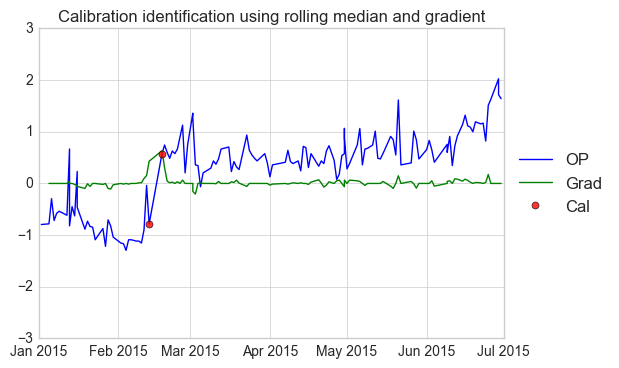

In [16]:
## get single linacs non-farmer data
df_l = all_data[(all_data['Linac_ID']==linac) & (all_data['Measurement_Device']!=device)].sort_values(by='Date')
if len(df_l)==0:
    df_l = all_data[(all_data['Linac_ID']==linac)].sort_values(by='Date')

## calculate rolling median
df_l['roll_med']=df_l['OP_Dif'].rolling(window=10,center=True).median().fillna(method='bfill').fillna(method='ffill')

## then look at the gradient?

## calculate the differential of the OPs and identify any calibration points baased on large gradients
df_l['grad']=df_l['roll_med'].diff()

## auto threshold based on SD
## calc SD of the grad
sd_grad = df_l['grad'].std()
thres = 5*sd_grad

## filter out those above/below a threshold
df_l_cal = df_l[(df_l['grad']>thres) | (df_l['grad']<-thres)]
print(linac,' : num cal points identified: ',len(df_l_cal))

## plot the data and gradient
plt.plot(df_l['Date'],df_l['OP_Dif'],label='OP')
plt.plot(df_l['Date'],df_l['grad'],label='Grad')
## works better when date is included as likely multiple measurements on the same day?

## plot the identified points that exceed the gradient threshold
plt.plot(df_l_cal['Date'],df_l_cal['OP_Dif'],marker='o',ls='',ms=5,alpha=0.8,c='red',label='Cal')

#plt.axhline(thres,c='black')
#plt.axhline(-thres,c='black')
plt.title('Calibration identification using rolling median and gradient')
plt.ylim(-3,3)
plt.xlim('01-jan-15','1-july-15')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
savename = 'OPs\Linac_OPs\OP-cal-med\op-cal-med-'+str(linac)+'.png'
#plt.savefig(savename,bbox_inches='tight',dpi=300)
plt.show()

## this works for linacs 10 and 11, but identifies 2 points on a single day for linac 11.
## this could probably be sorted by checking the dates afterwards and only selecting a single date?

## try cubic spline or similar interpolation to produce a smooth curve, then look at the gradient
- the gradient of smoothed data will be more well behaved (hopefully)

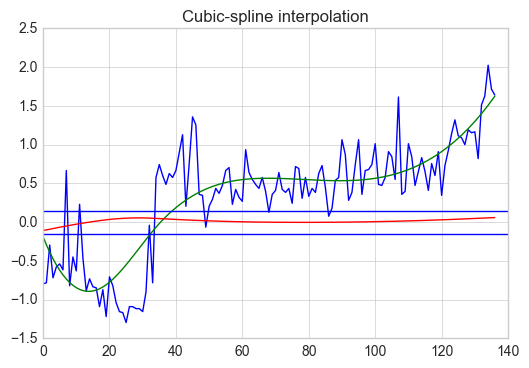

In [17]:
## calculate the smoothed data
#linac=11
## get single linacs non-farmer data
df_l = all_data[(all_data['Linac_ID']==linac) & (all_data['Measurement_Device']!=device)].sort_values(by='Date')
if len(df_l)==0:
    df_l = all_data[(all_data['Linac_ID']==linac)].sort_values(by='Date')

x = np.arange(0,len(df_l.index),1)
y = df_l['OP_Dif'].values

smoothing = 0.15*len(y)

tck = interpolate.splrep(x, y, s=smoothing,k=3)
xnew = x
ynew = interpolate.splev(xnew, tck, der=0)
ygrad = np.gradient(ynew)

plt.plot(x,y)
plt.plot(xnew,ynew)
plt.plot(xnew,ygrad)

test_thres = 0.15
plt.axhline(-test_thres)
plt.axhline(test_thres)

#plt.plot(x, y, 'x', xnew, ynew, xnew, np.sin(xnew), x, y, 'b')
#plt.legend(['Linear', 'Cubic Spline', 'True'])
#plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('Cubic-spline interpolation')
plt.show()

## this has the same problem in that it doesnt elimnate spikes.

### Calculate weekly mean/medians and work with those to identify which week calibration were in?

[0.11, -0.16399999999999998, -0.015, -0.33799999999999997, 0.23068661883333333, -0.14999999999999997, -0.16999999999999998, -0.05600000000000001, 0.152, -0.3214540103333333, -0.304, -0.14166666666666666, 0.088, 0.13999999999999999, 0.152, 0.142, 0.3099846906666667, 0.34, 1.278, 1.162, 1.334, 0.46017109233333336, -0.292, -1.112, -0.6816666666666666, -0.48200000000000004, -0.4770647766666667]


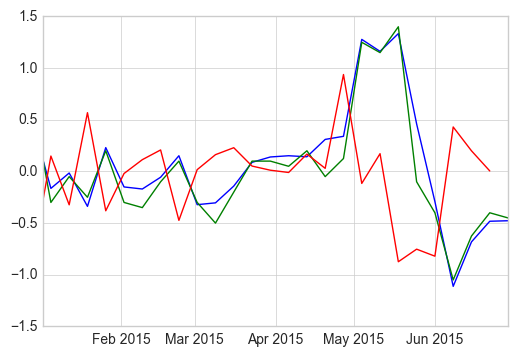

In [18]:
linac=10

df_l = all_data[(all_data['Linac_ID']==linac) & (all_data['Measurement_Device']!=device)].sort_values(by='Date')
if len(df_l)==0:
    df_l = all_data[(all_data['Linac_ID']==linac)].sort_values(by='Date')

## get list of the available weeks
weeks = df_l['Week'].unique()

## calc the mean from each week and save in a list
week_mean = []
week_med = []
week_start = []

for week in weeks:
    weekly_data = df_l[(df_l['Week']==week)]
    weekly_mean = weekly_data['OP_Dif'].mean()
    weekly_med = weekly_data['OP_Dif'].median()
    weekly_start = weekly_data['Date'].min()
    week_mean.append(weekly_mean)
    week_med.append(weekly_med)
    week_start.append(weekly_start)
    
print(week_mean)
plt.plot(week_start,week_mean)
plt.plot(week_start,week_med)
#plt.plot(df_l['Date'],df_l['OP_Dif'])
plt.plot(week_start[:-1],np.diff(week_mean))

#plt.plot(df_l['Date'][:-1],np.diff(df_l['OP_Dif']))

## get list of week start dates

- Seperating it into weeks has the disadvantage of removing the date of the calibration.
    - But possibly could still be acurate enough to then add on a dose ot all weeks following this?

## Try looking at difference between previous n and next n results to see if there is a large difference
- This might differentiate between spikes?
- Is this the same as the rolling median + gradient approach?
- Need to specify that a single value does not count somehow.
    - So a comparison of [prev,current,next] compared with [prev,prev1,prev2] and [next,next1,next2]?


## Try and fit a linear curve to each linac to assess gradients.
- This wont initially take into account calibrations, but most have not been calibrated within the period?
- Could eliminate those that definitely had calibrations?

- Need to convert the dates into a time (in days) since the 1/1/15 for the fitting funcitons to work.


In [19]:
def r_squared(actual, ideal):
    actual_mean = np.mean(actual)
    ideal_dev = np.sum([(val - actual_mean)**2 for val in ideal])
    actual_dev = np.sum([(val - actual_mean)**2 for val in actual])

    return ideal_dev / actual_dev

In [20]:
#linac=11

## input date
a = [0,1,3,5,6,8,9]
b = [1,0.4,2,3.4,6,8,9.1]

## do the fitting
res = np.polyfit(a,b,1)
p = np.poly1d(res)
slope = res[0]
intercept = res[1]

## fit data for plotting
#a_fit = np.linspace(min(a),max(a),100)
b_fit = p(a)

## plot results
#plt.plot(a,b,ls='',marker='o')
#plt.plot(a,b_fit)

def find_grad(x,y,x_start=None,x_stop=None):
    ## do the fitting
    res = np.polyfit(x[x_start:x_stop],y[x_start:x_stop],1)
    p = np.poly1d(res)
    slope = res[0]
    intercept = res[1]

    ## fit data for plotting
    #a_fit = np.linspace(min(a),max(a),100)
    b_fit = p(x[x_start:x_stop])
    return b_fit,slope,intercept


Grad: 0.001 % per day


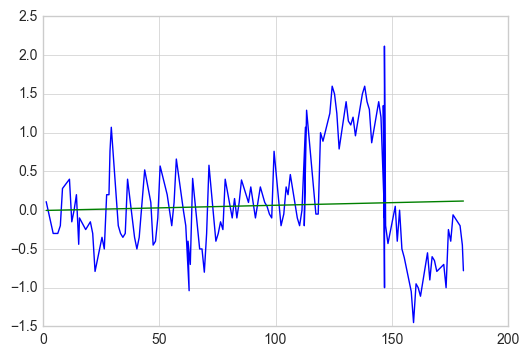

In [21]:
## test the function on 

start = None
stop = None

test = find_grad(df_l['date_delta'],df_l['OP_Dif'],start,stop)
plt.plot(df_l['date_delta'],df_l['OP_Dif'])
plt.plot(df_l['date_delta'][start:stop],test[0])
print('Grad:',round(test[1],3),'% per day')

C:\Users\mb22\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


Mean Gradient: 0.002 % per day
per year: 0.835
*** note that this includes all data including those with calibrations


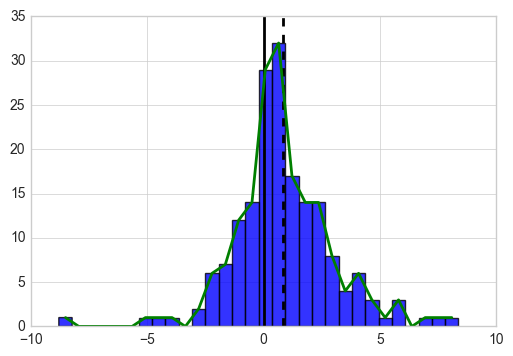

In [22]:
## calculate the gradient for each linac over the entire period

linacs = all_data['Linac_ID'].unique()

## check if a calibration happened for each linac

## make a new list of linacs which did not have a calibration as these will not provide reliable gradients
linacs_with_cal = [9,10,11,12,13,17,23,36,51,54,55,61,63,71,73,94,95,96,97,100,137,141,166,171,198]

#>>> list1 = ['paste', 'text', 'text', 'here', 'here', 'here', 'my', 'i', 'i', 'me', 'me']
#>>> list2 = ["i","me"]
#>>> list3 = [item for item in list1 if item not in list2]

linacs = [linac for linac in linacs if linac not in linacs_with_cal]
device = 'Farmer'

grads = []

date1='01-Jan-15'

for linac in linacs:
    ## get single linacs non-farmer data
    df_l = all_data[(all_data['Linac_ID']==linac) & (all_data['Measurement_Device']!=device)
                   & (all_data['Date']>date1)].sort_values(by='Date')
    if len(df_l)==0:
        df_l = all_data[(all_data['Linac_ID']==linac) & (all_data['Date']>date1)].sort_values(by='Date')
    grad_res = find_grad(df_l['date_delta'],df_l['OP_Dif'])
    grad = grad_res[1]*365 # convert to yearly gradient
    grads.append(grad)
    
grad_mean = np.mean(grads)

#print(grads)
n,bins,patches=plt.hist(grads, bins=30,alpha=0.8)
plt.axvline(grad_mean,c='black',lw=2,ls='--')
plt.axvline(0,c='black',lw=2)

print('Mean Gradient:',round(grad_mean/365,3),'% per day')
print('per year:',round(grad_mean,3))
print('*** note that this includes all data including those with calibrations')

## plot line on histogram with n and bins
plt.plot((bins[:-1]+0.5*(bins[1]-bins[0])),n,lw=2)

In [23]:
print(linacs)

[1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 56, 57, 58, 59, 60, 62, 64, 65, 66, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 98, 105, 102, 103, 108, 104, 99, 106, 101, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 143, 138, 139, 140, 149, 145, 147, 150, 148, 151, 144, 146, 152, 153, 154, 134, 155, 156, 157, 158, 159, 165, 142, 167, 168, 169, 170, 174, 173, 172, 160, 161, 162, 163, 164, 175, 176, 177, 178, 179, 182, 180, 181, 183, 184, 185, 186, 189, 190, 187, 188, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204]


### Produce plots for individual linacs containing:
- Line between each output measurement - DONE
- Different Markers for Farmer and Other Measurement Device - DONE
- Line indicating overall mean - DONE
- Plot of fitted linear curve - DONE
- Inidcate calibration points (use multiple methods to get the dates?)

** Do it from the raw data so its easy to reproduce the plots and add or remove things if required**

Started
 1/2 completed

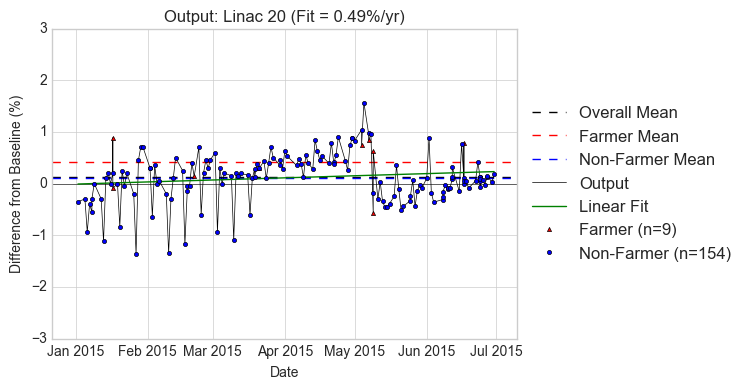

 2/2 completed

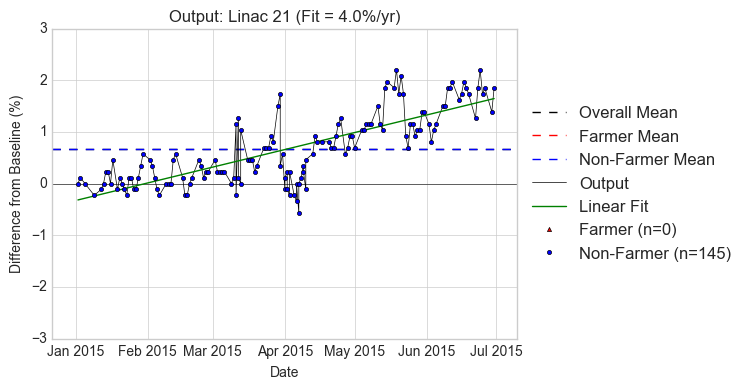

In [24]:
## get linacs
linacs = sorted(all_data['Linac_ID'].unique())
linacs=[20,21]

## filter data to get single linac and sort by date and narrow down to +/-4% to exclude some further outliers
print('Started')
i = 1
for linac in linacs:
    print("\r", (str(i) +'/' + str(len(linacs)) + ' completed'), end="")
    df_linac = all_data[(all_data['Linac_ID']==linac) & (all_data['OP_Dif']<=4) & (all_data['OP_Dif']>=-4)].sort_values(by='Date')

    ## get only the farmer and non-farmer data for plotting
    df_l_farmer = df_linac[df_linac['Farmer']=='Farmer']
    df_l_non = df_linac[df_linac['Farmer']!='Farmer']
    n_farmer = len(df_l_farmer)
    n_non = len(df_l_non)

    ## plot the overall mean and zero line
    linac_mean = df_linac['OP_Dif'].mean()
    linac_mean_farmer = df_l_farmer['OP_Dif'].mean()
    linac_mean_non = df_l_non['OP_Dif'].mean()
    plt.axhline(0,color='black',alpha=0.8,lw=0.5)
    plt.axhline(linac_mean,ls='--',color='black',lw=1,label='Overall Mean')
    plt.axhline(linac_mean_farmer,ls='--',color='red',lw=1,label='Farmer Mean ')
    plt.axhline(linac_mean_non,ls='--',color='blue',lw=1,label='Non-Farmer Mean')

    ## plot the single linacs OP
    plt.plot(df_linac['Date'],df_linac['OP_Dif'],color='black',lw=0.5,label='Output')

    ## fit linear curve to the data and plot
    fit_res = find_grad(df_linac['date_delta'],df_linac['OP_Dif']) # fit returns (yvals,slope,intercept)
    grad = round(fit_res[1]*365,2) # gradient per year
    #print('Grad:',round(fit_res[1],3),'% per day')

    ## plot the fit using the first and last y values and the first and last dates
    ## as cant use the data returned directly as its not the actual date.
    ## could turn it into dates as know the start date and days since.
    ## Would need to do that if used anything but a linear fit.
    daterange=[df_linac['Date'].min(),df_linac['Date'].max()]
    yvals = [fit_res[0][0],fit_res[0][-1]]
    plt.plot(daterange,yvals,color='green',label='Linear Fit')

    ## plot the farmer and non-farmer points
    plt.plot(df_l_farmer['Date'],df_l_farmer['OP_Dif'],ls='',marker='^',color='red',ms=3,label=('Farmer (n=' + str(n_farmer) + ')'))
    plt.plot(df_l_non['Date'],df_l_non['OP_Dif'],ls='',marker='o',color='blue',ms=3,label=('Non-Farmer (n=' + str(n_non) + ')'))

    ## add info to the plot
    plt.title('Output: Linac ' + str(linac) + ' (Fit = ' + str(grad) + '%/yr)')
    plt.xlabel('Date')
    plt.ylabel('Difference from Baseline (%)')
    plt.ylim(-3,3)
    plt.xlim('22-Dec-14','10-Jul-15')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ## save or display the plot
    savename = 'OPs\Linac_OPs\OP-trend_gradient\Linac_' + str(linac)+'.png'
    #plt.savefig(savename,bbox_inches='tight',dpi=300)
    #plt.close()
    i=i+1
    plt.show()